# Decision Analysis - Project 1 #


Mateusz Małecki <br>
Daniel Jankowski 148257

In [1]:
import pandas as pd
import numpy as np
import math
# from graphviz import Digraph # Graphviz engine installed is required for creating graphical rankings
import IPython
import copy

## Dataset ##

1. What is the domain of the problem about?

    <i>The domain of the problem is set of different cars available on the polish market</i>

2. What is the source of the data?

    <i>The data is taken from the website https://www.otomoto.pl/, where people or companies around Poland are selling their cars.</i>

3. What is the point of view of the decision maker?

    <i>The decision maker is looking for a car suitable for the city, therefore the finally choosen car should be not only powerful, but also economic.</i>

4. What is the number of alternatives considered? Were there more of them in the original data set?

    <i>We've gathered data about 22 cars. As a original dataset we may consider the website https://www.otomoto.pl/. For our search filters there were available more than 3000 cars.</i>

5. Describe one of the alternatives considered (give its name, evaluations, specify preferences for this
alternative)

    <i>Considering the first alternative from our dataset it is a Seat Ibiza from 2015 year. It has quite small engine (1.2) and fuel consumption (6.0) what is good, because we are looking for the car suitable for the city (economic). However, the power of the engine is not as good as it could be, it is only 90HP. The price is 34900pln what is the upper boundary looking through the entire dataset, but it's reasonable taking into account the mileage and production year of the car - the mileage is less than 100 000 when the car itself is not that old. Unfortunately this car doesn't have automatic gear box, however it's not the most important feature for us. Overall, the car looks good, however, the color of the car and, above all, the prestige of its brand almost disqualifies it as a good alternative.</i>

6. What is the number of criteria considered? Were there more of them in the original data set?

    <i>In our decision problem we consider 9 criteria, however, in the original problem of choosing the suitable car there are much more things we need to care about. Since we create our dataset by ourselves based on available data on the website, it's hard to say how many criteria there really is.</i>

7. What is the origin of the various criteria? (catalog parameter / created by the decision maker - how?)

    <i>Selecting the various criteria we wanted to focus on the most important features in case of car evaluation for us. As a students we would like to have an economic, but in the same time fast and prestigious car. Based on those factors we decided to keep criteria such as prestige of a given brand, the power (HP) of the car, fuel consumption and engine size. Moreover there are criteria typical in case of choosing the car like production year or mileage.</i>

8. What are the domains of the individual criteria (discrete / continuous)? Note: in the case of continuous domains, specify the range of the criterion’s variability, in the case of others: list the values. What is the nature (gain / cost) of the individual criteria?

    <i>
    <table>
        <tr>
            <th>
                Criterion
            </th>
            <th>Type</th>
            <th>Discrete / Continuous</th>
            <th>Values / Range</th>
        </tr>
        <tr>
            <td>Prestige</td><td>Gain</td><td>Discrete</td><td>{1,2,3,4,5,6,7,8,9,10}</td>
        </tr>
        <tr>
            <td>Power</td><td>Gain</td><td>Continuous</td><td><69;215></td>
        </tr>
        <tr>
            <td>Price</td><td>Cost</td><td>Continuous</td><td><27,300; 40,000></td>
        </tr>
        <tr>
            <td>Engine size</td><td>Cost</td><td>Continuous</td><td><1.0; 4.2></td>
        </tr>
        <tr>
            <td>Colour preference</td><td>Gain</td><td>Discrete</td><td>{1,2,3,4,5}</td>
        </tr>
        <tr>
            <td>Fuel consumption</td><td>Cost</td><td>Continuous</td><td><2.0; 15.0></td>
        </tr>
        <tr>
            <td>Mileage</td><td>Cost</td><td>Continuous</td><td><22,100; 301,000></td>
        </tr>
        <tr>
            <td>Production year</td><td>Gain</td><td>Continuous</td><td><1977; 2020></td>
        </tr>
        <tr>
            <td>Automatic gear box</td><td>Gain</td><td>Discrete (binary in fact)</td><td>{0,1}</td>
        </tr>
    </table>
    </i>

<!-- <br> -->

9. Are all criteria of equal importance (should they have the same ”weights”)? If not, can the relative
importance of the criteria under consideration be expressed in terms of weights? In this case, estimate
the weights of each criterion on a scale of 1 to 10. Are there any criteria among the criteria that are
completely or almost invalid / irrelevant?

    <i>Considered criteria are not equally important. We've estimate the importance of each criteria in the following way: <br>
    * Prestige: 7
    * Power: 7
    * Price: 8
    * Engine size: 7
    * Colour preference: 2
    * Fuel consumption: 8
    * Mileage: 10
    * Production year: 6
    * Automatic gear box: 3

    We may say that colour preference criteria and the automatic gear box are almost irrelevant in comparison to others.</i>


10. Are there dominated alternatives among the considered data set? If so, present all of them (dominating
and dominated alternative), giving their names and values on the individual criteria.

    <i>In our dataset it's hard to point a car that dominate each other.</i>


11. What should the theoretically best alternative look like in your opinion? Is it a small advantage on
many criteria, or rather a strong advantage on few (but key) criteria? Which?

    <i>Theoretically the best alternative should have much less mileage than other cars and it should not has worse power. It should be at the average level in case of production year and if possible belongs to the brand with the prestige in the upper bound value (7-10). </i>

12. Which of the considered alternatives (provide name and values on individual criteria) seems to be the best / definitely better than the others? Is it determined by one reason (e.g. definitely the lowest price) or rather the overall value of the criteria? Does this alternative still have any weaknesses?

    <i>The best alternative seems to be Peugeot 208 red. It has very small mileage in comparison to others cars, it has only 3 years and automatic gear box. However, this car still has som weaknesses, the price is high (34,000) and the prestige of the brand is low. Overall, based on how we estimated the weights of the criteria, such a good values in case of mileage and production year make this alternative seem to be the best.</i>

13. Which of the considered alternatives (provide name and values on individual criteria) seems to be the worst / definitely worse than the others? Is it determined by one reason (e.g. definitely the highest price), or rather the overall value of the criteria? Does this alternative still have any strengths?

    <i>The worst alternative seems to be Mercedes w116 brown. Despite the fact that the prestige and the power of the car is very good looking through the entire dataset, other criteria doesn't make that alternative a good option from the decision maker point of view. Large engine capacity and high fuel consumption combined with the distant year of production and very high mileage make this alternative look like one of the worst. </i>





In [2]:
data = pd.read_csv("DA_database.csv", decimal=",")

In [3]:
data.head()

,name,prestige,power,price,engine_size,colour_preference,fuel_consumption,mileage,production_year,automatic_gear_box
0,Seat Ibiza 1.2 white,1,90,34900,1.2,2,6.0,90000,2015,0
1,Seat Ibiza 1.4 green,1,85,27800,1.4,4,6.9,82000,2015,0
2,Skoda Fabia grey,4,75,31500,1.0,1,5.8,215000,2019,0
3,Nissan Note grey,3,80,28500,1.2,1,6.0,133000,2014,0
4,MINI Cooper 1.6 blue,7,175,27900,1.6,5,8.0,183000,2006,0


## Parameters for criteria

- Parameters we need for our algorithms to work are:
  - preference threshold
  - indifference threshold
  - weight
  - type of criteria (gain, or cost)
  - type of preference function
  These are provided bellow for all criteria

We used different types of preference functions for Promethee, which are described bellow:

- TYPE 1: Usual criterion
- TYPE 2: U-Shape criterion
- TYPE 3: V-Shape criterion
- TYPE 4: Level criterion
- TYPE 5: V-Shape with indif. criterion
- TYPE 6: Gaussian criterion

Formulas for preference functions were obtain from the lecture 1, except for TYPE 6, which was found in the paper from 2010, since formula on the lecture was incorrect (difference between alternatives is not squared).

In [18]:
params={
    "prestige":{
    "type":"gain", "func_type":"Type6", "p":2, "q":1, "w": np.float64
    },
    "power":{
    "type":"gain", "func_type":"Type5", "p":15, "q":5, "w":np.float64
    },
    "price":{
    "type":"cost", "func_type":"Type5", "p":3000, "q":1000, "w":np.float64
    },
    "engine_size":{
    "type":"cost", "func_type":"Type5", "p":0.2, "q":0, "w":np.float64
    },
    "colour_preference":{
    "type":"gain", "func_type":"Type4", "p":2, "q":1, "w":np.float64
    },
    "fuel_consumption":{
    "type":"cost", "func_type":"Type5", "p":0.3, "q":0.1, "w":np.float64
    },
    "mileage":{
    "type":"cost", "func_type":"Type6", "p":35000, "q":20000, "w":np.float64
    },
    "production_year":{
    "type": "gain", "func_type":"Type5", "p":3, "q":2, "w":np.float64
    },
    "automatic_gear_box":{
    "type":"gain", "func_type":"Type1", "p":1, "q":0, "w":np.float64
    },
}

### SRF procedure for defining weights ###

<b>The DM ranks the criteria in the following way (from the most important groups to the least important):</b>

L1: mileage <br>
<i>One white card</i> <br>
L2: fuel_consumption, price <br>
L3: prestige, power, engine_size <br>
L4: production_year <br>
<i>One white card</i> <br>
<i>One white card</i> <br>
L6: automatic_gearbox <br>
L7: colour_preference <br>

<b><i>Importance mileage to colour_preference is Z = 20 </i></b>

In [13]:
# Mapping between criteria string names and indices
NUM_CRITERIA = 9
CRITERIA2INDEX = {
    "prestige": 0,
    "power": 1,
    "price": 2,
    "engine_size": 3,
    "colour_preference": 4,
    "fuel_consumption": 5,
    "mileage": 6,
    "production_year": 7,
    "automatic_gear_box": 8
}

# Inverse dictionary that contains indices integers as keys and string names as values
INDEX2CRITERIA = {v: k for k, v in CRITERIA2INDEX.items()}

In [14]:
# List that contains information about how DM ranks the criteria into groups. 
# Each list from the up to bottom contains indices of criteria assigned to a given group
# Empty lists indicate the white card.
# In below list the first nested list contains only one integer (index) which is 6 what means 
# that in the first group we have only mileage criterion.
# Next, there is an empty list which means that here we have one white card etc.
L_GROUPS = [[6],
            [],
            [2,5],
            [0, 1, 3],
            [7],
            [],
            [],
            [8],
            [4]]

In [15]:
def compute_weights(z_ratio: int, L: list, n_criteria: int=9) -> np.array:
    # Number of groups which is the length of the list without empty lists, needed for computing r(t) - raw rank of a given group
    num_groups_left = len(L) - sum([1 for sublist in L if len(sublist) == 0])
    non_normalized_weights = np.zeros(n_criteria)
    # raw ranking of the best group
    r_v = len(L)
    for _, group in enumerate(L):
        if group:
            # r - place of the group + left white cards
            r = num_groups_left+sum([1 for sublist in L[_:] if len(sublist) == 0])
            # compute non-normalized weight for each criterion in group
            w = 1+(z_ratio-1)*(r-1)/(r_v-1)
            # put at the proper index the weight of each criterion in group
            np.put(non_normalized_weights, group, w)
            num_groups_left-=1
    return non_normalized_weights / sum(non_normalized_weights)       
    

In [19]:
WEIGHTS = compute_weights(z_ratio=20, L=L_GROUPS)
for i in range(NUM_CRITERIA):
    print(INDEX2CRITERIA[i],":", WEIGHTS[i])

prestige : 0.12379807692307693
power : 0.12379807692307693
price : 0.1466346153846154
engine_size : 0.12379807692307693
colour_preference : 0.009615384615384616
fuel_consumption : 0.1466346153846154
mileage : 0.19230769230769232
production_year : 0.10096153846153846
automatic_gear_box : 0.03245192307692308


### Applying calculated weights to main parameters

In [20]:
for i in range(NUM_CRITERIA):
    params[INDEX2CRITERIA[i]]["w"] = WEIGHTS[i]

## Promethe ##

Bellow there is implementation of Promethee I and II in one "Promethee" class.

To create an object of such a class, we need:

- A data frame, with possible alternatives, of a format as presented:

| name | Criteria\_1 | Criteria\_2 | … | Criteria\_n-1 | Criteria\_n |
| --- | --- | --- | --- | --- | --- |
| \<name of alternative 1\> | \<numerical evaluation on given criteria\> | \<numerical evaluation on given criteria\> | … | \<numerical evaluation on given criteria\> | \<numerical evaluation on given criteria\> |
| … | … | … | … | … | … |
| \<name of alternative n\> | … | … | … | … | … |

- A Python dictionary with parametes for given criteria, such us:
  - preference threshold
  - indifference threshold
  - weight
  - type of criteria (gain, or cost)
  - type of preference function

## Promethee implementation

In [ ]:
class Promethee:
    def __init__(self, alternatives: pd.DataFrame, parameters: dict[str, dict]) -> None:
        self.alternatives = alternatives
        self.parameters = parameters
        self.criteria = np.array([x for x in alternatives.columns[1:]])
        self.weights = np.expand_dims(np.array([x['w'] for x in parameters.values()]), axis=(1,2))


    def criteriaComparison(self, criteria: str, a, b, funcType: str) -> float:
        assert(funcType in ["Type1", "Type2", "Type3", "Type4", "Type5", "Type6"])
        p, q = self.parameters[criteria]["p"], self.parameters[criteria]["q"]
        diff = a - b if self.parameters[criteria]["type"] == "gain" else b-a
        if funcType == "Type1":
            return 1 if diff > 0 else 0
        
        elif funcType == "Type2":
            return 1 if diff > q else 0
        
        elif funcType == "Type3":
            if diff > p:
                return 1
            elif diff <= 0:
                return 0
            else:
                return diff / p
        
        elif funcType == "Type4":
            if diff > p:
                return 1
            elif diff < q:
                return 0
            else:
                return 0.5
        
        elif funcType == "Type5":
            if diff > p:
                return 1
            elif diff <= q:
                return 0
            else:
                return (diff - q)/(p-q)
        else:
            return 0 if diff <= 0 else 1 - math.exp(-(diff**2)/2) # assuming sd = 1
    
    def computeMarginalPreferencesAllCriteria(self) -> np.array:
        marginalPreferenceIndices = np.zeros((len(self.criteria), len(self.alternatives), len(self.alternatives)))
        for n, criteria in enumerate(self.criteria):
            for i, row in self.alternatives.iterrows():
                for j, row2 in self.alternatives.iterrows():
                    if i == j:
                        continue
                    marginalPreferenceIndices[n][i][j] = self.criteriaComparison(criteria, row[criteria], row2[criteria], self.parameters[criteria]["func_type"])
        return marginalPreferenceIndices
    
    def computeComprehensiveMatrix(self) -> np.array:
        return np.sum(self.computeMarginalPreferencesAllCriteria() * self.weights, axis=0)/sum(self.weights)
    
    def computePositiveFlows(self, matrix) -> np.array:
        return np.sum(matrix, axis = 1)
    def computeNegativeFlows(self, matrix) -> np.array:
        return np.sum(matrix, axis = 0)
    
    def prometheeIdrawRanking(self, preference):
        ranking = copy.deepcopy(preference)
        dot = Digraph(format='png')
        removed = set()
        for x in self.alternatives["name"]:
            for y in self.alternatives["name"]:
                for z in self.alternatives["name"]:
                    if y in preference[x] and z in preference[y] and z in preference[x] and (x, z) not in removed:
                        removed.add((x, z))
                        ranking[x].remove(z)
        for x in self.alternatives["name"]:
            dot.node(x, x)
        for node, outranked in ranking.items():
            for out in outranked:
                dot.edge(node, out)
        dot.render(view=True)
        return dot
    

    def prometheeI(self, drawRanking = True, printRelations = False):
        X = self.computeComprehensiveMatrix()
        positive_flows = dict([x for x in zip(self.alternatives["name"], self.computePositiveFlows(X))])
        negative_flows = dict([x for x in zip(self.alternatives["name"], self.computeNegativeFlows(X))])
        positive_flows_l = sorted([x for x in zip(self.alternatives["name"], self.computePositiveFlows(X))], key=lambda x:x[1])
        negative_flows_l = sorted([x for x in zip(self.alternatives["name"], self.computeNegativeFlows(X))], key=lambda x:x[1], reverse=True)

        preferences = {}
        incomparable_indifferent = {}

        for alternative1 in self.alternatives["name"]:
            preferences[alternative1] = []
            incomparable_indifferent[alternative1] = []
            for alternative2 in self.alternatives["name"]:
                if alternative1 == alternative2:
                    continue
                if (positive_flows[alternative1] > positive_flows[alternative2] and negative_flows[alternative1] < negative_flows[alternative2]) or (positive_flows[alternative1] == positive_flows[alternative2] and negative_flows[alternative1] < negative_flows[alternative2]) or (positive_flows[alternative1] > positive_flows[alternative2] and negative_flows[alternative1] == negative_flows[alternative2]):
                    preferences[alternative1].append(alternative2)
                else:
                    incomparable_indifferent[alternative1].append(alternative2)
        if printRelations:
            for x in self.alternatives["name"]:
                print(f"{x} outranks {preferences[x]}")
                print(f"{x} is incomparable or indifferent to {incomparable_indifferent[x]}\n")
        if drawRanking:
            return self.prometheeIdrawRanking(preferences)
    
    def prometheeIIdrawRanking(self, flow):
        dot = Digraph(strict=True, format='png')
        for x in self.alternatives["name"]:
            dot.node(x, x)
        values = [x[1] for x in flow]
        ranking_temp = [[x[0] for x in flow if x[1] == y] for y in values]
        ranking = []
        for item in ranking_temp:
            if item not in ranking:
                ranking.append(item)
        for i in range(1, len(ranking)):
                prev_node = ranking[i-1]
                curr_node = ranking[i]
                for x in prev_node:
                    for y in curr_node:
                        dot.edge(y, x)
        dot.render(view=True)
        return dot

    def prometheeIIprintRelations(self, ranking):
        outrank = {x:[] for x in self.alternatives["name"]}
        indifferent = {x:[] for x in self.alternatives["name"]}
        for x in ranking:
            for y in ranking:
                if x == y:
                    continue
                if x[1] > y[1]:
                    outrank[x[0]].append(y[0])
                elif x[1] == y[1]:
                    indifferent[x[0]].append(y[0])
        for x in self.alternatives["name"]:
            print(f"{x} outranks {outrank[x]}")
            print(f"{x} is indifferent to {indifferent[x]}\n")

    def prometheeII(self, drawRanking = True, printRelations = False):
        X = self.computeComprehensiveMatrix()
        balance = sorted([x for x in zip(self.alternatives["name"], self.computePositiveFlows(X) - self.computeNegativeFlows(X))], key=lambda x:x[1])
        if printRelations: self.prometheeIIprintRelations(balance)
        if drawRanking: return self.prometheeIIdrawRanking(balance)

### For checking validity of obtained results, we provided algorithm with the data from the lab classes
Cells are wrapped for better readability

In [ ]:
lab = {"name":["a1", "a2", "a3", "a4", "a5", "a6", "a7", "a8"],
            "g1":[5,4,5,5,2,8,3,2], "g2":[4,1,0,2,0,5,2,5],
            "g3":[70,54,71,60,81,55,97,73], "g4":[12,11,17,15,11,13,19,14]}
lab_data = pd.DataFrame(lab)
params_lab={
    "g1":{
    "type":"gain", "func_type":"Type5", "p":5, "q":0, "v":None, "w":0.09
    },
    "g2":{
    "type":"gain", "func_type":"Type5", "p":1, "q":1, "v":None, "w":0.29
    },
    "g3":{
    "type":"gain", "func_type":"Type5", "p":23, "q":6, "v":None, "w":0.25
    },
    "g4":{
    "type":"cost", "func_type":"Type5", "p":4, "q":2, "v":None, "w":0.37
    }
}

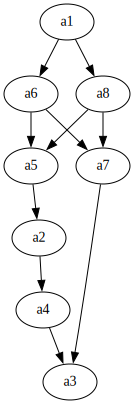

In [ ]:
solver = Promethee(lab_data, params_lab)
solver.prometheeI()

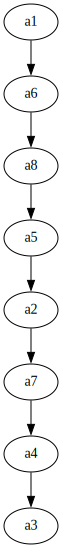

In [ ]:
solver.prometheeII()

### Now, solution to our car choosing problem by PrometheeI and PrometheeII are presented bellow

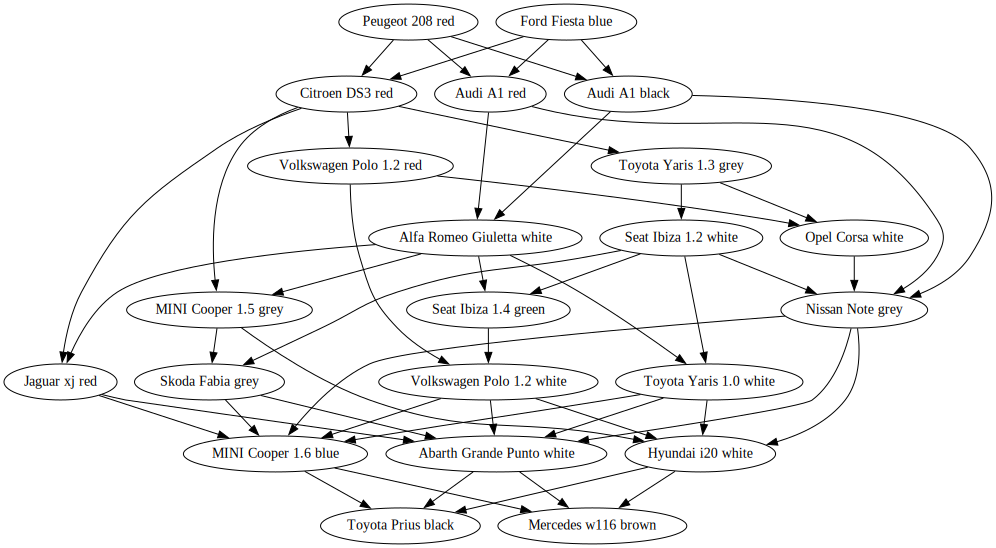

In [ ]:
# Promethee I
decisionMaker = Promethee(data, params)
decisionMaker.prometheeI()

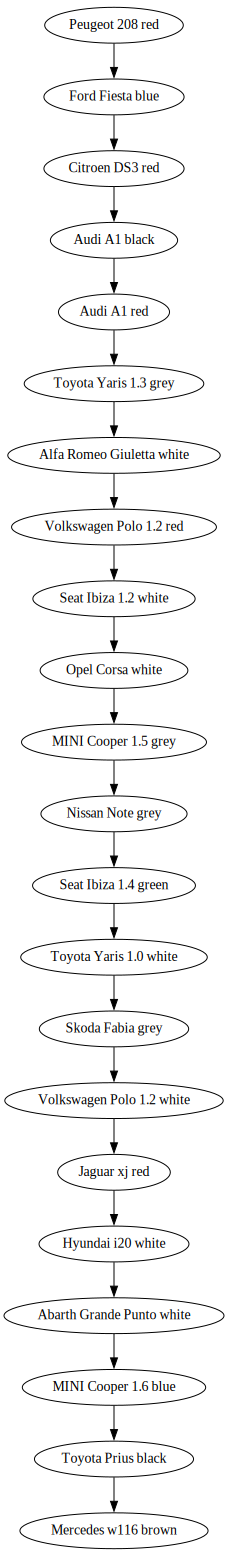

In [ ]:
# Promethee II
decisionMaker.prometheeII()

When comparing Obtained rankings, we can clearly see, that the red Peugeot 208 and blue Ford Fiesta are preferred to all other options. In the case of Promethee I they are incomparable (or indifferent) since their parameters are quite similar and both look very good in comparison to the rest of the alternatives. In Promethee II, since there is no such thing as incomparability, Peugeot wins with Ford by a small margin.

To compare those two rankings, we assume that alternatives at the same level (horizontally) in the ranking of Promethee I are "similar" (they are incomparable or indifferent because they are unable to outrank each other), thus they should be in close neighborhood in ranking created by Promethee II. What's more, in both rankings the higher the alternative places, the better it is.

After analyzing both rankings, it can be clearly seen, that our assumption is true. The only inconsistency is Alfa Romeo, which was rated a little bit better in Promethee II than in Promethee I.

What surprised us was that the initial parameters resulted in satisfying performance. Peugeot was one of the best choices, and the Mercedes was the worst one.
However, in Promethee I, blue Ford was the other best choice, which is understandable while looking at the data we provided. In our initial choice blue Ford wasn't considered one of the potential best choices. It's quite hard to explain why, but for some reason it doesn't seem to be the best option. While it has similar power, and slightly lower fuel consumption, it is 5 years older and has a very small engine. Even though engine size is a cost criteria, the popular opinion is very harsh for such small engines, it is thought that they might break easier. So this is some bias that we as a decision maker had while picking the best option, but after a longer analysis of obtained results, the ranking of Promethee I was very reasonable.
To slightly improve the performance, we changed preference function types for given criteria, and modified weights.

## Electre Tri-B ##

### Input for the method ###

As in input paramters for the method we have to define several matrices:

<b>In each array which holds values for criteria, the order of criteria is the same as before in case of calculating weights (consistent with INDEX2CRITERIA dictionary)</b>

- Boundaries - matrix with boundaries values between specific classes. Since we consider 4 classes, we defined values for 3 boundary profiles. 
- Thresholds - matrix with thresholds values between specific classes for all criteria. For each boundary profile the thresholds are defined seperately in case of changing some of them in the future. In all three sub-matrices the first row corresponds to the p values, second for q values and the third for veto.
- Criteria types - list with information about the types of criteria
- Alternatives - matrix with values of all alternatives, it might be easily read into matrix from pandas dataframe as in the following cells

In [4]:
# Mapping between a specific class to its name
_CLASSES = {
    1: "the worst",
    2: "bad",
    3: "better",
    4: "the best"
}

In [5]:
# boundary profiles evaluations
# each row has 9 values which indicates boundary for each criterion
BOUNDARIES = np.array([
    [2, 90, 37000, 2, 1.5, 7.1, 170000, 2000, 0], # b1 - boundary between the worst and bad class
    [5, 106, 33000, 1.6, 3.5, 6.6, 140000, 2010, 0], # b2 - boundary between bad and better class
    [8, 130, 30000, 1.2, 4.5, 5.9, 100000, 2017, 0.5] # b3 - boundary between better and the best class
])

In [6]:
b1_thresholds = np.array([
    [2, 15, 3000, 0.2, 0, 0.3, 35000, 4, 1], # p
    [1, 5, 1000, 0, 0, 0.1, 20000, 2, 0], # q
    [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 50000, np.inf, np.inf] # veto values, only for mileage criterion
])

b2_thresholds = np.array([
    [2, 15, 3000, 0.2, 0, 0.3, 35000, 4, 1], # p
    [1, 5, 1000, 0, 0, 0.1, 20000, 2, 0], # q
    [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 50000, np.inf, np.inf] # veto values, only for mileage criterion
])

b3_thresholds = np.array([
    [2, 15, 3000, 0.2, 0, 0.3, 35000, 4, 1], # p
    [1, 5, 1000, 0, 0, 0.1, 20000, 2, 0], # q
    [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 50000, np.inf, np.inf] # veto values, only for mileage criterion
])
# For now all parameters (p, q, veto) are the same for all boundary profiles.

THRESHOLDS = np.array([
    b1_thresholds,
    b2_thresholds, 
    b3_thresholds
])

CRITERIA_TYPES = ["gain","gain","cost","cost","gain","cost","cost","gain","gain"]

In [7]:
ALTERNATIVES = data.loc[:, data.columns!='name'].to_numpy()

In [21]:
from typing import Tuple


class ElectreTriB:
    def __init__(self, 
                 alternatives: np.array,
                 boundaries: np.array,
                 thresholds: np.array,
                 criteria_types: list[str],
                 weights: np.array,
                 num_criteria: int = NUM_CRITERIA,
                 ) -> None:
        self.alternatives = alternatives
        self.num_alternatives = alternatives.shape[0]
        
        self.num_criteria = num_criteria
        self.boundaries = boundaries
        self.num_bound_profiles = thresholds.shape[0]
        
        self.thresholds = thresholds
        
        self.criteria_types = criteria_types
        self.weights = weights
        
    def compute_concordance_value_gain(self, a, b, p, q) -> float:
        diff = a-b
        if diff >= -q:
            return 1
        elif diff < -p:
            return 0
        else:
            return (p-(b-a))/(p-q)
            
        
    def compute_concordance_value_cost(self, a, b, p, q) -> float:
        diff = a-b
        if diff <= q:
            return 1
        elif diff > p:
            return 0
        else:
            return (p-(a-b))/(p-q)
        
        
    def compute_marginal_concordance_vectors(self, boundaries, thresholds) -> Tuple[np.array, np.array]:
        conc_matrix = np.zeros(shape=(self.num_alternatives, self.num_criteria))
        conc_matrix_inv = np.zeros(shape=(self.num_alternatives, self.num_criteria))
        
        _concordance_values_mappers = {
            "gain": self.compute_concordance_value_gain,
            "cost": self.compute_concordance_value_cost
        }
        
        for i in range(self.num_alternatives):
            for j in range(self.num_criteria):
                # read p and q value from threshold array
                p, q = thresholds[0][j], thresholds[1][j]
                g_a = self.alternatives[i][j]
                # read a boundary value of a profile for a given criterion
                g_b = boundaries[j]
                criterion_type = self.criteria_types[j]
                conc_matrix[i][j] = _concordance_values_mappers[criterion_type](
                    g_a, g_b, p, q
                )
                conc_matrix_inv[i][j] = _concordance_values_mappers[criterion_type](
                    g_b, g_a, p, q
                )
                
        # Compute the vector C(a, b_h) for all alternatives
        # this vector is one column of the final comprehensive concordance matrix
        #  C(a, b)      |  b_1  |  b_2  |  b_3
        #  -------------------------------------
        #   a1          |       |       |
        #   a2          |       |       |
        
        conc_vector = np.dot(conc_matrix, self.weights) / self.weights.sum()
        conc_vector_inv = np.dot(conc_matrix_inv, self.weights) / self.weights.sum()
                
        return (conc_vector, conc_vector_inv)
    
    def compute_discordance_value_gain(self, a: int, b: int, p: int, v: int) -> float:
        diff = a-b
        if diff <= -v:
            return 1
        elif diff >= -p:
            return 0
        else:
            return ((b-a)-p)/(v-p)
        
    def compute_discordance_value_cost(self, a: int, b: int, p: int, v: int) -> float:
        diff = a-b
        if diff >= v:
            return 1
        elif diff <= p:
            return 0
        else:
            return (v-(a-b))/(v-p)
    
    def compute_marginal_discordance_matrices(self, boundaries: np.array, thresholds: np.array) -> Tuple[np.array, np.array]:
        disc_matrix = np.zeros(shape=(self.num_alternatives, self.num_criteria))
        disc_matrix_inv = np.zeros(shape=(self.num_alternatives, self.num_criteria))
        
        _discordance_values_mappers = {
            "gain": self.compute_discordance_value_gain,
            "cost": self.compute_discordance_value_cost
        }
        
        for i in range(self.num_alternatives):
            for j in range(self.num_criteria):
                # read p and q value from threshold array
                p, v = thresholds[0][j], thresholds[2][j]
                g_a = self.alternatives[i][j]
                # read a boundary value of a profile for a given criterion
                g_b = boundaries[j]
                criterion_type = self.criteria_types[j]
                disc_matrix[i][j] = _discordance_values_mappers[criterion_type](
                    g_a, g_b, p, v
                )
                disc_matrix_inv[i][j] = _discordance_values_mappers[criterion_type](
                    g_b, g_a, p, v
                )
                
        return (np.nan_to_num(disc_matrix), np.nan_to_num(disc_matrix_inv))
    
    
    def compute_credibility_vectors(self,
                                      conc_vector: np.array,
                                      conc_vector_inv: np.array,
                                      disc_matrix: np.array,
                                      disc_matrix_inv: np.array) -> Tuple[np.array, np.array]:
        credibility = np.zeros(shape=(self.num_alternatives))
        credibility_inv = np.zeros(shape=(self.num_alternatives))
        
        for i in range(self.num_alternatives):
            credit_value = conc_vector[i]
            credit_inv_value = conc_vector_inv[i]
            for j in range(self.num_criteria):
                if disc_matrix[i][j] > conc_vector[i]:
                    credit_value *= (1-disc_matrix[i][j])/(1-conc_vector[i])
                if disc_matrix_inv[i][j] > conc_vector_inv[i]:
                    credit_inv_value += (1-disc_matrix_inv[i][j])/(1-conc_vector_inv[i])
            credibility[i] = credit_value
            credibility_inv[i] = credit_inv_value
        
        return (credibility, credibility_inv)
    
    def compute_relations(self, 
                          credibility: np.array,
                          credibility_inv: np.array,
                          lambda_cut: float = 0.7) -> list[str]:
        relations = []
        for i in range(self.num_alternatives):
            if credibility[i] >= lambda_cut and credibility_inv[i] < lambda_cut:
                relations.append(">")
            elif credibility[i] < lambda_cut and credibility_inv[i] >= lambda_cut:
                relations.append("<")
            elif credibility[i] >= lambda_cut and credibility_inv[i] >= lambda_cut:
                relations.append("I")
            elif credibility[i] < lambda_cut and credibility_inv[i] < lambda_cut:
                relations.append("?")
        return relations
        
    
    def make_classification_optimistic(self, relations: list[str], classes: dict[int, str]):
        for i, e in enumerate(relations):
            if e == "<":
                return classes[i+1]
        return classes[4]
            
        
    def make_classification_pessimistic(self, relations: list[str], classes: dict[int, str]):
        for i, e in reversed(list(enumerate(relations))):
            if e == "I" or e == ">":
                return classes[i+2]
        return classes[1]
        
    def classify_alternatives(self, alternatives_names: list[str], classes: dict[int, str], lambda_cut: float = 0.7):
        data_results = {"name": alternatives_names}
        
        results = pd.DataFrame(data_results)
        
        for i in range(self.num_bound_profiles):
            boundaries = self.boundaries[i]
            thresholds = self.thresholds[i]
            
            conc_vector, conc_vector_inv = self.compute_marginal_concordance_vectors(boundaries, thresholds)
            disc_matrix, disc_matrix_inv = self.compute_marginal_discordance_matrices(boundaries, thresholds)
            
            credibility, credibility_inv = self.compute_credibility_vectors(conc_vector,
                                                                            conc_vector_inv, 
                                                                            disc_matrix,
                                                                            disc_matrix_inv)
            
            relations = self.compute_relations(credibility, credibility_inv, lambda_cut)
            results["b"+str(i+1)] = relations
        # results = results.reset_index()
        pessimistic = []
        optimistic = []
        for _, row in results.iterrows():
            relations = [row.b1, row.b2, row.b3]
            pessimistic_class = self.make_classification_pessimistic(relations, classes)
            pessimistic.append(pessimistic_class)
            optimistic_class = self.make_classification_optimistic(relations, classes)
            optimistic.append(optimistic_class)
        results["PES(a)"] = pessimistic
        results["OPT(a)"] = optimistic
            
            
            
        return results
    

In [22]:
electre = ElectreTriB(
    alternatives=ALTERNATIVES,
    boundaries=BOUNDARIES,
    thresholds=THRESHOLDS,
    criteria_types=CRITERIA_TYPES,
    weights=WEIGHTS
    
)

In [23]:
alternatives_names = data['name'].to_list()

In [50]:
results_electre = electre.classify_alternatives(alternatives_names, lambda_cut=0.70, classes=_CLASSES)
results_electre


C:\Users\janko\AppData\Local\Temp\ipykernel_49124\3561420967.py:97: RuntimeWarning: invalid value encountered in double_scalars
  return (v-(a-b))/(v-p)
C:\Users\janko\AppData\Local\Temp\ipykernel_49124\3561420967.py:97: RuntimeWarning: invalid value encountered in double_scalars
  return (v-(a-b))/(v-p)
C:\Users\janko\AppData\Local\Temp\ipykernel_49124\3561420967.py:97: RuntimeWarning: invalid value encountered in double_scalars
  return (v-(a-b))/(v-p)


,name,b1,b2,b3,PES(a),OPT(a)
0,Seat Ibiza 1.2 white,>,?,<,bad,better
1,Seat Ibiza 1.4 green,>,?,<,bad,better
2,Skoda Fabia grey,?,?,<,the worst,better
3,Nissan Note grey,>,>,<,better,better
4,MINI Cooper 1.6 blue,>,?,<,bad,better
5,Opel Corsa white,>,>,<,better,better
6,Toyota Yaris 1.3 grey,I,I,<,better,better
7,Citroen DS3 red,I,>,<,better,better
8,Volkswagen Polo 1.2 white,>,?,<,bad,better
9,Toyota Yaris 1.0 white,>,?,<,bad,better


In the first run of the method with lambda parameter equals to 0.7 we can clearly see that most of the results are close to each other, specially in case of optimistic classification. None of the alternatives reached <i>the best</i> class, however in the optimistic classification, most of them was placed in the <i>better</i> class. In case of pessimistic assignments the classification is more diverse. In this case, bad and better classes were distributed almost evenly. Moreover, some of the alternatives reached the worst possible class.

Considering the alternatives which we indicated as the best and the worst, the Pueogeot 208 red was assigned to the <i>better</i> class in both pessimistic and optimistic way of classification. Nine others alternatives obtained same result. However, according to our preferences, Mercedes w116 brown was classified to the worst class in both ways of assigning.

<b>Slightly adjusting the weights of the criteria by adding blank cards</b>

Tha aim of this procedure is to increase the importance of mileage criteria.

In [75]:
L_GROUPS_NEW = [[6],
            [],
            [],
            [],
            [],
            [],
            [],
            [2,5],
            [],
            [],
            [0, 1, 3],
            [],
            [],
            [7],
            [],
            [],
            [8],
            [4]]

WEIGHTS_NEW = compute_weights(z_ratio=20, L=L_GROUPS_NEW)
for i in range(NUM_CRITERIA):
    print(INDEX2CRITERIA[i],":", WEIGHTS_NEW[i])

prestige : 0.1111111111111111
power : 0.1111111111111111
price : 0.15333333333333332
engine_size : 0.1111111111111111
colour_preference : 0.012592592592592591
fuel_consumption : 0.15333333333333332
mileage : 0.2518518518518518
production_year : 0.06888888888888889
automatic_gear_box : 0.026666666666666665


In [76]:
electre_new = ElectreTriB(
    alternatives=ALTERNATIVES,
    boundaries=BOUNDARIES,
    thresholds=THRESHOLDS,
    criteria_types=CRITERIA_TYPES,
    weights=WEIGHTS_NEW
    
)

In [77]:
results_electre_new = electre_new.classify_alternatives(alternatives_names, lambda_cut=0.7, classes=_CLASSES)
results_electre_new

C:\Users\janko\AppData\Local\Temp\ipykernel_49124\3561420967.py:97: RuntimeWarning: invalid value encountered in double_scalars
  return (v-(a-b))/(v-p)
C:\Users\janko\AppData\Local\Temp\ipykernel_49124\3561420967.py:97: RuntimeWarning: invalid value encountered in double_scalars
  return (v-(a-b))/(v-p)
C:\Users\janko\AppData\Local\Temp\ipykernel_49124\3561420967.py:97: RuntimeWarning: invalid value encountered in double_scalars
  return (v-(a-b))/(v-p)


,name,b1,b2,b3,PES(a),OPT(a)
0,Seat Ibiza 1.2 white,>,?,<,bad,better
1,Seat Ibiza 1.4 green,>,?,<,bad,better
2,Skoda Fabia grey,?,?,<,the worst,better
3,Nissan Note grey,>,>,<,better,better
4,MINI Cooper 1.6 blue,>,?,<,bad,better
5,Opel Corsa white,>,>,<,better,better
6,Toyota Yaris 1.3 grey,I,I,<,better,better
7,Citroen DS3 red,>,>,<,better,better
8,Volkswagen Polo 1.2 white,>,?,<,bad,better
9,Toyota Yaris 1.0 white,>,?,<,bad,better


To obtain the final results, we've added blank cards after the group of the strongest criteria (mileage criterion). Since the mileage is one of the most important criteria, it seemed reasonable to increase weight for this measure. After running method once again with the new weights, Peugeot 208 red has been classified to the best class in case of optimistic assignment what is valid with our expectations. 


Looking at the other alternatives, most of them were still assigned to the better class, specially in case of optimistic way of classification. This might be caused by quite high requirements which have to be met for this class.

## Comparison of obtained results ##

Comparing the results from all methods we may observe that in each case, the results are quite similar, especially when it comes to choosing the best and worst alternatives. Each method unanimously chose the Mercedes as the worst option. Regarding the Electre Tri-B method, to distinguish the best car among all it was necessary to slightly ajust the weights. Using the same weights for Electre Tri-B as in case of Promethee made it impossible to select one the best option. 


When it comes to alternatives that rank in the middle of the Promethee method rankings, in the case of Electre Tri-B it is hard to determine which alternatives are better than each other based only on their assignment to particular classes. However, there still exists a correlation which says that alternatives which are higher in the Promethee rankings also reached better classes in case of Electre method (i.e. in most of cases an alternative that reached in both pessimistic and optimistic assignment 'better' class, in Promethee rankings is higher than alternative with e.g. pessimistic - 'bad' and optimistic - 'better' assignment).


It is worth to notice that the car which in Promethee I was at the same level as our personal best choice (Peugeot 208 red), in the final assignment in Electre Tri-B method didn't reach as good results. The reason why this happened is because of the changed weights of the criteria for the final results of Electre Tri-B. Ford Fiesta blue has worse mileage value in comparison to Peugeot and after increasing the importance of that criteria it was no longer as good as previously (at least based on classes assigned to each of those alternatives).

Overall, it is normal for the results to vary between the methods as each has slightly different characteristics, but either way the results obtained are quite consistent and in line with our initial assumptions.